# 卷积神经网络文本分类

## 模型构建与训练

### 定义网络结构

In [1]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout


class TextCNN(object):
    def __init__(self, maxlen, max_features, embedding_dims,
                 class_num=5,
                 last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation

    def get_model(self):
        input = Input((self.maxlen,))
        embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)(input)
        convs = []
        for kernel_size in [3, 4, 5]:
            c = Conv1D(128, kernel_size, activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)

        output = Dense(self.class_num, activation=self.last_activation)(x)
        model = Model(inputs=input, outputs=output)
        return model

### 数据处理与训练

In [2]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from utils import *

# 路径等配置
data_dir = "./processed_data"
vocab_file = "./vocab/vocab.txt"
vocab_size = 40000

# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 256
embedding_dims = 50
epochs = 2

print('数据预处理与加载数据...')
# 如果不存在词汇表，重建
if not os.path.exists(vocab_file):  
    build_vocab(data_dir, vocab_file, vocab_size)
# 获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
words, word_to_id = read_vocab(vocab_file)

# 全部数据
x, y = read_files(data_dir)
data = list(zip(x,y))
del x,y
# 乱序
random.shuffle(data)
# 切分训练集和测试集
train_data, test_data = train_test_split(data)
# 对文本的词id和类别id进行编码
x_train = encode_sentences([content[0] for content in train_data], word_to_id)
y_train = to_categorical(encode_cate([content[1] for content in train_data], cat_to_id))
x_test = encode_sentences([content[0] for content in test_data], word_to_id)
y_test = to_categorical(encode_cate([content[1] for content in test_data], cat_to_id))

print('对序列做padding，保证是 samples*timestep 的维度')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)


数据预处理与加载数据...
对序列做padding，保证是 samples*timestep 的维度
x_train shape: (65810, 100)
x_test shape: (21937, 100)


In [3]:
print('构建模型...')
model = TextCNN(maxlen, max_features, embedding_dims).get_model()
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

print('训练...')

# 设定callbacks回调函数
my_callbacks = [
    ModelCheckpoint('./cnn_model.h5', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=2, mode='max')
]

# fit拟合数据
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

#print('对测试集预测...')
#result = model.predict(x_test)

构建模型...
训练...
Train on 65810 samples, validate on 21937 samples
Epoch 1/2
65792/65810 [============================>.] - ETA: 0s - loss: 0.6880 - accuracy: 0.7623
Epoch 00001: saving model to ./cnn_model.h5
65810/65810 [==============================] - 83s 1ms/sample - loss: 0.6879 - accuracy: 0.7623 - val_loss: 0.2935 - val_accuracy: 0.9036
Epoch 2/2
65792/65810 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9349
Epoch 00002: saving model to ./cnn_model.h5
65810/65810 [==============================] - 82s 1ms/sample - loss: 0.1957 - accuracy: 0.9349 - val_loss: 0.2633 - val_accuracy: 0.9106


### 训练中间信息输出

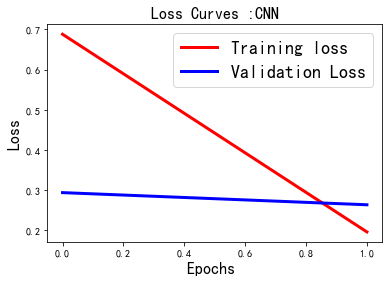

In [4]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

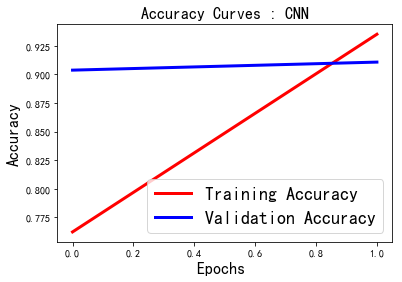

In [5]:
fig2=plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

### 模型结构打印

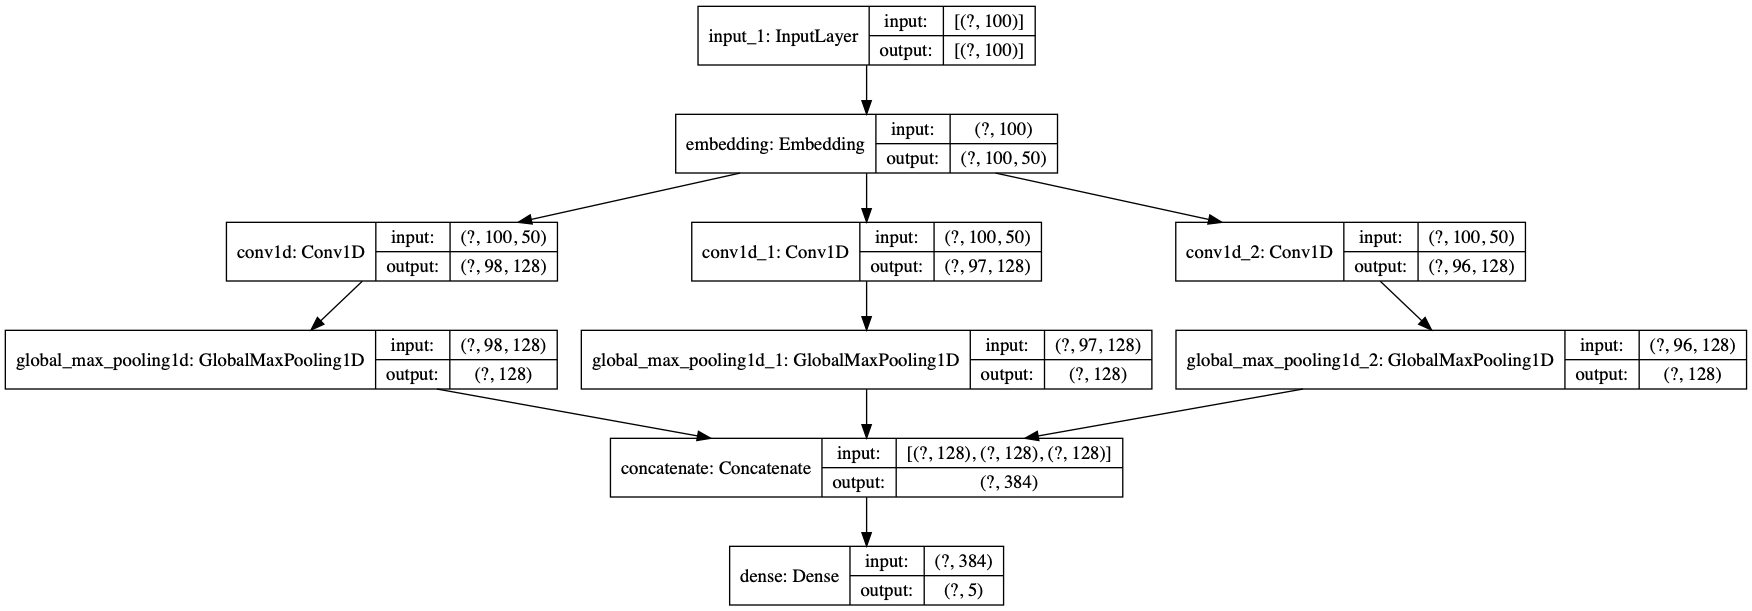

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

## 模型的导出与检查

### 模型导出

In [177]:
import tensorflow as tf
import shutil 

model = tf.keras.models.load_model('./cnn_model.h5')

# 指定路径
# if os.path.exists('./Models/CNN/1'):
#     shutil.rmtree('./Models/CNN/1')
    
# export_path = './Models/CNN/1'

# # 导出tensorflow模型以便部署
# tf.saved_model.save(model,export_path)

# 指定路径
if os.path.exists('./Models/RNN/1'):
    shutil.rmtree('./Models/RNN/1')
    
export_path = './Models/RNN/1'

# 导出tensorflow模型以便部署
tf.saved_model.save(model,export_path)

INFO:tensorflow:Assets written to: ./Models/RNN/1/assets


INFO:tensorflow:Assets written to: ./Models/RNN/1/assets


In [178]:
import jieba
text = "杨幂好漂亮,发生原子弹"
print(jieba.lcut(text))
text_seg = encode_sentences([jieba.lcut(text)], word_to_id)
text_input = sequence.pad_sequences(text_seg, maxlen=maxlen)

['杨幂', '好', '漂亮', ',', '发生', '原子弹']


In [179]:
print(model.predict(text_input))
a = model.predict(text_input)


[[0.00735603 0.974295   0.0024016  0.00155786 0.01438948]]


In [180]:
import numpy as np
np.argmax(a)

1

### 模型的部署前检查与测试

## 模型部署与服务构建介绍

In [181]:
import os
# 获取当前绝对路径
MODEL_DIR = os.getcwd()+"/Models/RNN"
os.environ["MODEL_DIR"] = MODEL_DIR
print(MODEL_DIR)

/Volumes/Untitled/NLP项目/docker部署/flask_news_classifier/Models/RNN


In [163]:
# %%bash --bg 
# nohup tensorflow_model_server --rest_api_port=8501 --model_base_path="${MODEL_DIR}" >server.log 2>&1

## 用Docker启动tf serving

### source这里一定要写绝对路径

###  target这里要写/models/自定义名字(比如rnn_serving)

### MODEL_NAME 和target的自定义名字一样

In [164]:
# --model_base_path="${MODEL_DIR}" 
# source=/Volumes/Untitled/NLP项目/docker部署/flask_news_classifier/Models/CNN,target=/models/rnn_serving

In [182]:
%%bash --bg 
docker run -p 8501:8501 --mount type=bind,source="${MODEL_DIR}",target=/models/rnn_serving -e MODEL_NAME=rnn_serving -t tensorflow/serving & >server.log 2>&1


In [175]:
! tail server.log

In [176]:
!pip install -q requests

tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.24.1 which is incompatible.
tensorboard 2.0.2 has requirement setuptools>=41.0.0, but you'll have setuptools 28.8.0 which is incompatible.
markdown 3.1.1 has requirement setuptools>=36, but you'll have setuptools 28.8.0 which is incompatible.
google-auth 1.10.0 has requirement setuptools>=40.3.0, but you'll have setuptools 28.8.0 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 测试数据预处理

In [169]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from utils import *
import json
import numpy
import requests
import jieba

# 路径等配置
data_dir = "./processed_data"
vocab_file = "./vocab/vocab.txt"
vocab_size = 40000

# 神经网络配置
max_features = 40001
maxlen = 100
batch_size = 256
embedding_dims = 50
epochs = 8

print('数据预处理与加载数据...')
# 如果不存在词汇表，重建
if not os.path.exists(vocab_file):  
    build_vocab(data_dir, vocab_file, vocab_size)
# 获得 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
words, word_to_id = read_vocab(vocab_file)

数据预处理与加载数据...


###  字典数据转换成json格式,使用request请求

In [170]:
text = "杨幂好漂亮,发生原子弹"
print(jieba.lcut(text))
text_seg = encode_sentences([jieba.lcut(text)], word_to_id)
text_input = sequence.pad_sequences(text_seg, maxlen=maxlen)

data = json.dumps({"signature_name": "serving_default",
                   "instances": text_input.reshape(1,100).tolist()})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/rnn_serving:predict',
                              data=data, headers=headers)

['杨幂', '好', '漂亮', ',', '发生', '原子弹']


### 呈现出测试数据的类别

In [171]:
print(json.loads(json_response.text))
# print(json_response.text.split(':')[1].strip()[2:-9])
# print(json_response.text.split(':')[1].strip()[2:-9].split(','))
proba = json_response.text.split(':')[1].strip()[2:-9].split(',')
proba
proba = [float(i) for i in proba]
print(proba)

import numpy as np
#
news_dict = {'0': 'car', '1':'entertainment', '2':'military', '3':'sports', '4':'technology'}
print('News Type:',news_dict[str(np.argmax(proba))])

{'predictions': [[0.00735603366, 0.974295, 0.00240160106, 0.00155786274, 0.0143894823]]}
[0.00735603366, 0.974295, 0.00240160106, 0.00155786274, 0.0143894823]
News Type: entertainment
